In [1]:
import argparse
import os
import pathlib
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))
from arg_parsing_utils import parse_args
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

profile_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot/NF1_organoid_data")).resolve(),
    root_dir,
)

In [2]:
patient_data_path = pathlib.Path(f"{profile_base_dir}/data/patient_IDs.txt").resolve(
    strict=True
)
patients = pd.read_csv(patient_data_path, header=None, names=["patient_ID"])[
    "patient_ID"
].tolist()

In [3]:
stats_output_path = pathlib.Path(
    f"{profile_base_dir}/data/all_patient_profiles/"
).resolve()
stats_output_path.mkdir(parents=True, exist_ok=True)

In [4]:
stats_files = []
for patient in patients:
    stats_path = pathlib.Path(
        f"{profile_base_dir}/data/{patient}/extracted_features/run_stats/"
    ).resolve(strict=True)

    for file_path in stats_path.glob("*.parquet"):
        if file_path.is_file():
            stats_files.append(file_path)
stats_files.sort()
print(f"Found {len(stats_files)} stats files for {len(patients)} patients.")

Found 426525 stats files for 12 patients.


In [5]:
def safe_read_parquet(stats_file):
    """Safely read a Parquet file and handle errors.
    This is primarily to continue through code in the event of corrupted files."""

    try:
        return pd.read_parquet(stats_file)
    except ValueError as e:
        print(f"Error reading {stats_file}: {e}")
        return None

In [6]:
dataframes = []
for stats_file in stats_files:
    df_temp = safe_read_parquet(stats_file)
    if df_temp is not None:
        dataframes.append(df_temp)
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
else:
    df = pd.DataFrame()

In [7]:
# comment out for now as we only used CPU
# df["feature_type_and_gpu"] = (
#     df["feature_type"].astype(str) + "_" + df["gpu"].astype(str)
# )
# df["feature_type_and_gpu"] = df["feature_type_and_gpu"].str.replace("None", "CPU")
# df["feature_type_and_gpu"] = df["feature_type_and_gpu"].str.replace("True", "GPU")
df["time_taken_minutes"] = df["time_taken"] / 60
df["mem_usage_GB"] = df["mem_usage"] / (1024)
df.to_parquet(
    f"{stats_output_path}/all_patient_featurization_stats.parquet", index=False
)

df.head()

,start_time,end_time,start_mem,end_mem,time_taken,mem_usage,gpu,well_fov,patient_id,feature_type,channel,compartment,time_taken_minutes,mem_usage_GB
0,1.764021e+09,1.764023e+09,158.640625,3285.304688,1981.573719,3126.664062,CPU,C10-1,NF0014_T1,Granularity,AGP,Cell,33.026229,3.053383
1,1.764021e+09,1.764021e+09,187.324219,1751.273438,34.689696,1563.949219,CPU,C10-1,NF0014_T1,Intensity,AGP,Cell,0.578162,1.527294
2,1.764021e+09,1.764021e+09,138.113281,1680.851562,101.077928,1542.738281,CPU,C10-1,NF0014_T1,Texture,AGP,Cell,1.684632,1.506580
3,1.764021e+09,1.764023e+09,160.191406,3285.628906,2667.117624,3125.437500,CPU,C10-1,NF0014_T1,Granularity,AGP,Cytoplasm,44.451960,3.052185
4,1.764021e+09,1.764021e+09,187.710938,1748.738281,35.707930,1561.027344,CPU,C10-1,NF0014_T1,Intensity,AGP,Cytoplasm,0.595132,1.524441


## Preliminary plots - will finalize in R later

/tmp/ipykernel_155678/3025699817.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Feature Type", bbox_to_anchor=(1.05, 1), loc="upper left")


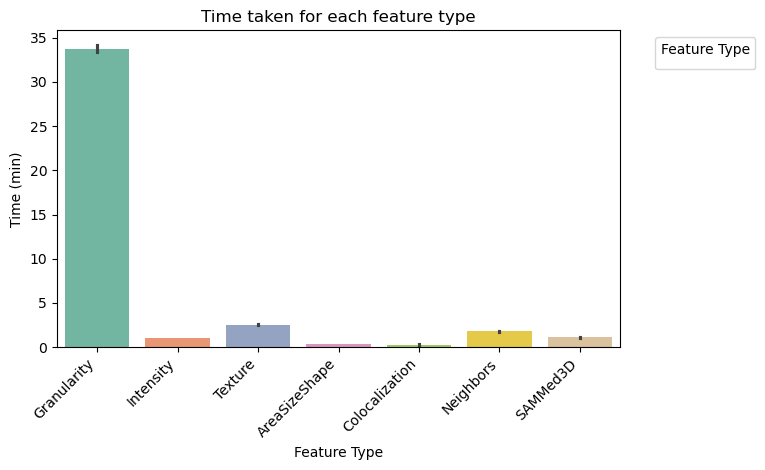

/tmp/ipykernel_155678/3025699817.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Feature Type", bbox_to_anchor=(1.05, 1), loc="upper left")


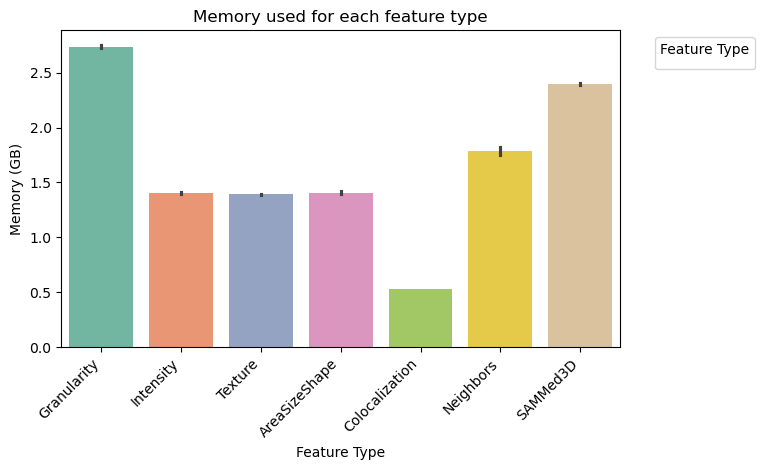

In [8]:
# plot the memory and time for each feature type
if in_notebook:
    sns.barplot(
        data=df,
        x="feature_type",
        y="time_taken_minutes",
        hue="feature_type",
        palette="Set2",
    )
    plt.title("Time taken for each feature type")
    plt.xlabel("Feature Type")
    plt.ylabel("Time (min)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    # move the legend outside the plot
    plt.legend(title="Feature Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

    sns.barplot(
        data=df,
        x="feature_type",
        y="mem_usage_GB",
        hue="feature_type",
        palette="Set2",
    )
    plt.title("Memory used for each feature type")
    plt.xlabel("Feature Type")
    plt.ylabel("Memory (GB)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(title="Feature Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.show()